In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
with open('screen_info.txt','rb') as fl:
    t = pickle.load(fl)
fnames = t[0]
totf = t[1]
binf = t[2]
runfile = 0
fname = fnames[runfile]
bf = binf[runfile]
print(fname)

AID362


In [3]:
path = os.getcwd() + '/bioassay-datasets/'+fname+'red_train.csv'
p_fingerprints = []
c_fingerprints = []
labels = []
with open(path) as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints.append(row[:bf])
        c_fingerprints.append(row[bf:-1])
        labels.append(row[-1])

In [4]:
p_fingerprints = np.asarray(p_fingerprints)[1:]
p_fingerprints = p_fingerprints.astype(int)
#p_fingerprints[(p_fingerprints==0)] = -1

c_fingerprints = np.asarray(c_fingerprints)[1:]
c_fingerprints = c_fingerprints.astype(float)

#Normalise the features
c_fingerprints = (c_fingerprints - np.mean(c_fingerprints,axis=0))/np.std(c_fingerprints,axis=0)

fingerprints = np.concatenate((p_fingerprints,c_fingerprints),axis=1)

#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = fingerprints.shape
labels = labels[1:]

In [5]:
labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0
labels2 = labels2.astype(int)
total_pos = np.sum(labels2)
tot_neg = no_examples - total_pos
print("tot_positive",total_pos)


('tot_positive', 48)


In [6]:
p_active = (p_fingerprints[labels2[:,0]==1])
p_inactive = (p_fingerprints[labels2[:,0]==0])

In [7]:
ham_pos = np.zeros((total_pos,total_pos))
for i in range(total_pos):
    for j in range(i):
        ham_pos[i,j] = ham_pos[j,i] = np.sum(np.absolute(p_active[i] - p_active[j]))

In [8]:
#pd.DataFrame(ham_pos)

In [9]:
ham_neg = np.zeros((tot_neg,tot_neg))
for i in range(tot_neg):
    for j in range(i):
        ham_neg[i,j] = ham_neg[j,i] = np.sum(np.absolute(p_inactive[i] - p_inactive[j]))

In [10]:
#pd.DataFrame(ham_neg)

In [11]:
ham_mix = np.zeros((total_pos,tot_neg))
for i in range(total_pos):
    for j in range(tot_neg):
        ham_mix[i,j] = np.sum(np.absolute(p_active[i] - p_inactive[j]))

In [12]:
#pd.DataFrame(ham_mix)

###  Find avg Hamming Distance:

In [13]:
mean_neg = np.mean(ham_neg,axis=0)
var_neg = np.std(ham_neg,axis=0)
#pd.DataFrame(mean_neg,var_neg)

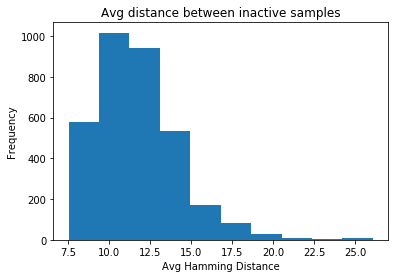

In [14]:
plt.hist(mean_neg)
plt.title("Avg distance between inactive samples")
plt.xlabel("Avg Hamming Distance")
plt.ylabel("Frequency")

fig = plt.gcf()
plt.show()
plt.show()

In [17]:
#print(mean_neg.shape)
ind_inact = np.argmin(mean_neg)
print(ind_inact)

153


In [18]:
mean_pos = np.mean(ham_pos,axis=0)
var_pos = np.std(ham_pos,axis=0)
#pd.DataFrame(mean_pos,var_pos)

In [19]:
ind_act = np.argmin(mean_pos)
print(ind_act)

38


In [20]:
save_act = p_active[ind_act,:]
save_inact = p_inactive[ind_inact,:]

In [21]:
save_list = [save_act,save_inact]
path = os.getcwd() + '/' + 'minham_' + fname
with open(path,'wb') as fn:
    pickle.dump(save_list,fn)

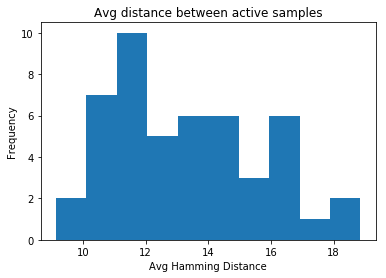

In [22]:
#import plotly.plotly as py
plt.hist(mean_pos)
plt.title("Avg distance between active samples")
plt.xlabel("Avg Hamming Distance")
plt.ylabel("Frequency")

fig = plt.gcf()
plt.show()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

#plt.show()

In [19]:
mean_pos_from_neg = np.mean(ham_mix,axis=1)
print(mean_pos_from_neg.shape)
std_pos_from_neg = np.std(ham_mix,axis=1)
#pd.DataFrame(mean_pos_from_neg,std_pos_from_neg)

(22,)


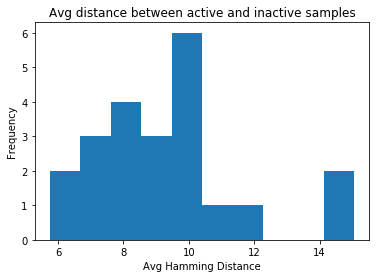

In [20]:
plt.hist(mean_pos_from_neg)
plt.title("Avg distance between active and inactive samples")
plt.xlabel("Avg Hamming Distance")
plt.ylabel("Frequency")

fig = plt.gcf()
plt.show()
plt.show()

In [21]:
diff = mean_pos - mean_pos_from_neg
#pd.DataFrame(diff)

#### Test using hamming distance

In [63]:
#path = os.getcwd() + '/bioassay-datasets/'
tp_fingerprints = []
tc_fingerprints = []
tlabels = []
with open(path) as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        tp_fingerprints.append(row[:bf])
        tc_fingerprints.append(row[bf:-1])
        tlabels.append(row[-1])

In [64]:
tp_fingerprints = np.asarray(tp_fingerprints)[1:]
tp_fingerprints = tp_fingerprints.astype(int)
#p_fingerprints[(p_fingerprints==0)] = -1

tc_fingerprints = np.asarray(tc_fingerprints)[1:]
tc_fingerprints = tc_fingerprints.astype(float)

#Normalise the features
tc_fingerprints = (tc_fingerprints - np.mean(tc_fingerprints,axis=0))/np.std(tc_fingerprints,axis=0)

tfingerprints = np.concatenate((tp_fingerprints,tc_fingerprints),axis=1)

#p2_fingerprints = np.ones(p_fingerprints.shape)
(tno_examples , tip_dim) = tfingerprints.shape
tlabels = tlabels[1:]

In [65]:
tlabels2 = np.zeros((len(tlabels),1))
for i,l in enumerate(tlabels):
    if l=='Active':
        tlabels2[i] = 1
    else:
        tlabels2[i] = 0
tlabels2 = tlabels2.astype(int)

In [66]:
test_with_neg = np.zeros((tno_examples,tot_neg))
for i in range(tno_examples):
    for k in range(int(tot_neg)):
        test_with_neg[i][k] = np.sum(np.abs(tp_fingerprints[i] - p_inactive[k]))

In [67]:
mean_with_neg = np.mean(test_with_neg,axis=1)
pd.DataFrame(mean_with_neg)

,0
0,7.707651
1,9.615924
2,13.063379
3,7.903911
4,9.363198
5,7.754791
6,5.868000
7,7.140444
8,9.104440
9,11.832923


In [68]:
test_with_pos = np.zeros((tno_examples,total_pos))
for i in range(tno_examples):
    for k in range(int(total_pos)):
        test_with_pos[i][k] = np.sum(np.abs(tp_fingerprints[i] - p_active[k]))

In [69]:
mean_with_pos  = np.mean(test_with_pos,axis=1)
#pd.DataFrame(mean_with_pos)

In [ ]:
ind_ac = np.argmin(mean_pos)
ind_inac = np.argmin(mean_neg)
p_act = p_fingerprints[ind_ac,:]
p_inc = p_fingerprints[ind_inac,:]

In [70]:
test_diff = mean_with_neg - mean_with_pos
op_pred = np.zeros(test_diff.shape)
op_pred[test_diff >= 0] = 1
op_pred[test_diff < 0] = 0
cf = metrics.confusion_matrix(tlabels2,op_pred).ravel()

In [71]:
cf

array([19728,  1825,   167,    31])